In [1]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim
from torch.nn.modules.loss import *
from Loss.triplet import *
from session import *
from LR_Schedule.cyclical import Cyclical
from LR_Schedule.cos_anneal import CosAnneal
from LR_Schedule.lr_find import lr_find
from callbacks import *
from validation import *
from validation import _AccuracyMeter
import Datasets.ImageData as ImageData
from Transforms.ImageTransforms import *
import util
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from torch.utils.tensorboard import SummaryWriter
from session import LossMeter, EvalModel
%matplotlib notebook

/home/drake/anaconda3/envs/.torch/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/drake/anaconda3/envs/.torch/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/drake/anaconda3/envs/.torch/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/drake/anaconda3/envs/.

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
torch.cuda.set_device(0); torch.backends.cudnn.benchmark=True;

/home/drake/anaconda3/envs/.torch/lib/python3.7/site-packages/torch/cuda/__init__.py:135: UserWarning: 
    Found GPU0 GeForce GTX 770 which is of cuda capability 3.0.
    PyTorch no longer supports this GPU because it is too old.
    The minimum cuda capability that we support is 3.5.
    
  warnings.warn(old_gpu_warn % (d, name, major, capability[1]))


In [4]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

fulltrainset = datasets.MNIST('/media/drake/MX500/Datasets/mnist/train', download=True, train=True, transform=transform)
trainset = torch.utils.data.dataset.Subset(fulltrainset, np.arange(1600))

fullvalset = datasets.MNIST('/media/drake/MX500/Datasets/mnist/test', download=True, train=False, transform=transform)
valset = torch.utils.data.dataset.Subset(fullvalset, np.arange(4480))

trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=False)

In [5]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

In [6]:
class TripletRegularizedCrossEntropyLoss(nn.Module):
    def __init__(self, alpha, margin):     
        super().__init__()
        self.alpha = alpha
        self.margin = margin
        
    def forward(self, x, y):
        loss = F.cross_entropy(x[-1], y)
        triplet = 0
        if (self.alpha > 0):
            for layer in x[:-1]:
                triplet += batch_hard_triplet_loss(layer.view(layer.size(0), -1), y, self.margin)

            triplet *= self.alpha
            
        return loss + triplet

In [7]:
class CustomOneHotAccuracy(OneHotAccuracy):
    def __init__(self):
        super().__init__()
        self.reset()

    def update(self, output, label):
        return super().update(output[-1], label)

In [8]:
class EmbeddingSpaceValidator(TrainCallback):
    def __init__(self, val_data, num_embeddings, accuracy_meter_fn):
        self.val_data = val_data
        self.val_accuracy_meter = accuracy_meter_fn()
        self.train_accuracy_meter = accuracy_meter_fn()
        self.num_embeddings=num_embeddings
        
        self.train_accuracies = []
        self.batch_train_accuracies = []
        self.val_accuracies = []
        
        self.train_losses = []
        self.batch_train_losses = []
        self.val_losses = []
        
        self.batch_train_embedding_losses = [[] for x in range(self.num_embeddings)]
        self.val_embedding_losses = [[] for x in range(self.num_embeddings)]
        
        self.num_batches = 0
        self.num_epochs = 0
        
        self.epochs = []

    def run(self, session, lossMeter=None):
        self.val_accuracy_meter.reset()
            
        val_loss = LossMeter()      
        embedding_losses = [LossMeter() for x in range(self.num_embeddings)]
        
        with EvalModel(session.model):
            for input, label, *_ in tqdm(self.val_data, desc="Validating", leave=True):
                label = Variable(util.to_gpu(label))
                output = session.forward(input)
                step_loss = session.criterion(output, label).data
                val_loss.update(step_loss, input.shape[0])
                self.val_accuracy_meter.update(output, label)
                    
                for layer, embedding_loss in zip(output[:-1], embedding_losses):
                    embedding_loss.update(batch_all_triplet_loss(layer.view(layer.size(0), -1), label, 1).data.cpu())
        
        self.val_losses.append(val_loss.raw_avg.data.cpu().item())
        self.val_accuracies.append(self.val_accuracy_meter.accuracy())
        
        for meter, loss in zip(embedding_losses, self.val_embedding_losses):
            loss.append(meter.raw_avg.data.cpu().item())     
        
    def on_epoch_begin(self, session):
        self.train_accuracy_meter.reset()     
        
    def on_epoch_end(self, session, lossMeter): 
        self.train_accuracies.append(self.train_accuracy_meter.accuracy())
        self.train_losses.append(lossMeter.debias.data.cpu().item())
        self.run(session, lossMeter) 
        self.epochs.append(self.num_batches)
        self.num_epochs += 1
    
    def on_batch_end(self, session, lossMeter, output, label):
        label = Variable(util.to_gpu(label))
        batch_accuracy = self.train_accuracy_meter.update(output, label)
        self.batch_train_accuracies.append(batch_accuracy)
        self.batch_train_losses.append(lossMeter.loss.data.cpu().item())
        
        for layer, embedding_loss in zip(output[:-1], self.batch_train_embedding_losses):
            embedding_loss.append(batch_all_triplet_loss(layer.view(layer.size(0), -1), label, 1).data.cpu().item())
            
        self.num_batches += 1
            
    def plot(self):
        fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize=(15, 15))
        
        #ax.plot(np.arange(self.num_batches), self.batch_train_accuracies)
        #legend.append("Train accuracy per batch")
        
        #ax.plot(np.arange(self.num_batches), self.batch_train_losses)
        #legend.append("Train loss per batch")
            
        ax1.plot(self.epochs, self.train_accuracies, '-o', label="Training accuracy per epoch")

        ax1.plot(self.epochs, self.val_accuracies, '-o', label="Validation accuracy per epoch")
        
        ax2.plot(self.epochs, self.train_losses, '-o', label="Training loss per epoch")
        
        ax2.plot(self.epochs, self.val_losses, '-o', label="Validation loss per epoch")
        
        for embedding in self.batch_train_embedding_losses:
            ax3.plot(np.arange(self.num_batches), embedding, label="Train embedding triplet loss per batch")
        
        for embedding in self.val_embedding_losses:
            ax3.plot(self.epochs, embedding, '-o', label="Validation embedding triplet loss per epoch")
            
        for ax in (ax1, ax2, ax3):
            box = ax.get_position()
            ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
            ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))   

In [9]:
class SelectiveSequential(nn.Module):
    def __init__(self, to_select, modules_dict):
        super(SelectiveSequential, self).__init__()
        for key, module in modules_dict.items():
            self.add_module(key, module)
        self._to_select = to_select
    
    def forward(self, x):
        list = []
        for name, module in self._modules.items():
            x = module(x)
            if name in self._to_select:
                list.append(x)
        return list
    
model = SelectiveSequential(
    ['fc1', 'fc2', 'out'],
    {'conv32a': nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
     #'batch32a': nn.BatchNorm2d(32),
     'act32a': nn.ReLU(),
    
     'conv32b': nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
     #'batch32b': nn.BatchNorm2d(32),
     'act32b': nn.ReLU(),
     
     'max1': nn.MaxPool2d(kernel_size=2, stride=2),
    
     'conv64a': nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
     #'batch64a': nn.BatchNorm2d(64),
     'act64a': nn.ReLU(),
     
     'conv64b': nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
     #'batch64b': nn.BatchNorm2d(64),
     'act64b': nn.ReLU(),
    
     'max2': nn.MaxPool2d(kernel_size=2, stride=2),
    
     'conv128a': nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
     #'batch128a': nn.BatchNorm2d(128),
     'act128a': nn.ReLU(),
     
     'conv128b': nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
     # 'batch128b': nn.BatchNorm2d(128),
     'act128b': nn.ReLU(),
     
     # 'max3': nn.MaxPool2d(kernel_size=2, stride=2),
    
     'flatten': Flatten(),
    
     'fc1': nn.Linear(7 * 7 * 128, 512),
     #'drop1': nn.Dropout(.05),
     'fc2': nn.Linear(512, 256),
     #'drop1': nn.Dropout(.05),
     'out': nn.Linear(256, 10)})

In [10]:
criterion = TripletRegularizedCrossEntropyLoss(0, 1)

In [11]:
sess = Session(model, criterion, optim.Adam, 1e-3)

In [12]:
sess.set_lr(1e-4)

In [13]:
validator = EmbeddingSpaceValidator(valloader, 2, CustomOneHotAccuracy)
lr_scheduler = CosAnneal(len(trainloader) * 60, T_mult=1, lr_min=1e-6)
schedule = TrainingSchedule(trainloader, [lr_scheduler, validator])
sess.train(schedule, 60)

Validating: 100%|██████████| 70/70 [00:01<00:00, 45.42it/s]


Validating: 100%|██████████| 70/70 [00:01<00:00, 45.47it/s]


Validating: 100%|██████████| 70/70 [00:01<00:00, 44.88it/s]


Validating: 100%|██████████| 70/70 [00:01<00:00, 45.52it/s]


Validating: 100%|██████████| 70/70 [00:01<00:00, 45.19it/s]


Validating: 100%|██████████| 70/70 [00:01<00:00, 44.76it/s]


Validating: 100%|██████████| 70/70 [00:01<00:00, 43.68it/s]


Validating: 100%|██████████| 70/70 [00:01<00:00, 45.12it/s]


Validating: 100%|██████████| 70/70 [00:01<00:00, 44.08it/s]


Validating: 100%|██████████| 70/70 [00:01<00:00, 45.05it/s]


Validating: 100%|██████████| 70/70 [00:01<00:00, 43.81it/s]


Validating: 100%|██████████| 70/70 [00:01<00:00, 43.17it/s]


Validating: 100%|██████████| 70/70 [00:01<00:00, 44.78it/s]


Validating: 100%|██████████| 70/70 [00:01<00:00, 45.25it/s]


Validating: 100%|██████████| 70/70 [00:01<00:00, 45.32it/s]


Validating: 100%|██████████| 70/70 [00:01<00:00, 45.28it/s]


Validating: 100%|██████████| 70/70 [00:01<00:00, 45.27it/s]


Validating: 100%|██████████| 70/70 [00:01<00:00, 40.43it/s]


Validating: 100%|██████████| 70/70 [00:01<00:00, 43.86it/s]


Validating: 100%|██████████| 70/70 [00:01<00:00, 44.37it/s]


Validating: 100%|██████████| 70/70 [00:01<00:00, 43.29it/s]


Validating: 100%|██████████| 70/70 [00:01<00:00, 44.33it/s]


Validating: 100%|██████████| 70/70 [00:01<00:00, 45.23it/s]


Validating: 100%|██████████| 70/70 [00:01<00:00, 45.54it/s]


Validating: 100%|██████████| 70/70 [00:01<00:00, 45.68it/s]


Validating: 100%|██████████| 70/70 [00:01<00:00, 45.71it/s]


Validating: 100%|██████████| 70/70 [00:01<00:00, 43.87it/s]


Validating: 100%|██████████| 70/70 [00:01<00:00, 44.53it/s]


Validating: 100%|██████████| 70/70 [00:01<00:00, 45.44it/s]


Validating: 100%|██████████| 70/70 [00:01<00:00, 45.31it/s]


Validating: 100%|██████████| 70/70 [00:01<00:00, 44.29it/s]


Validating: 100%|██████████| 70/70 [00:01<00:00, 45.26it/s]


Validating: 100%|██████████| 70/70 [00:01<00:00, 45.17it/s]


Validating: 100%|██████████| 70/70 [00:01<00:00, 45.24it/s]


Validating: 100%|██████████| 70/70 [00:01<00:00, 44.08it/s]


Validating: 100%|██████████| 70/70 [00:01<00:00, 45.07it/s]


Validating: 100%|██████████| 70/70 [00:01<00:00, 44.65it/s]


Validating: 100%|██████████| 70/70 [00:01<00:00, 45.23it/s]


Validating: 100%|██████████| 70/70 [00:01<00:00, 45.35it/s]


Validating: 100%|██████████| 70/70 [00:01<00:00, 44.20it/s]


Validating: 100%|██████████| 70/70 [00:01<00:00, 44.18it/s]


Validating: 100%|██████████| 70/70 [00:01<00:00, 45.11it/s]


Validating: 100%|██████████| 70/70 [00:01<00:00, 45.00it/s]


Validating: 100%|██████████| 70/70 [00:01<00:00, 45.55it/s]


Validating: 100%|██████████| 70/70 [00:01<00:00, 44.28it/s]


Validating: 100%|██████████| 70/70 [00:01<00:00, 45.01it/s]


Validating: 100%|██████████| 70/70 [00:01<00:00, 41.85it/s]


Validating: 100%|██████████| 70/70 [00:01<00:00, 41.45it/s]


Validating: 100%|██████████| 70/70 [00:01<00:00, 45.17it/s]


Validating: 100%|██████████| 70/70 [00:01<00:00, 45.58it/s]


Validating: 100%|██████████| 70/70 [00:01<00:00, 45.46it/s]


Validating: 100%|██████████| 70/70 [00:01<00:00, 44.17it/s]


Validating: 100%|██████████| 70/70 [00:01<00:00, 43.08it/s]


Validating: 100%|██████████| 70/70 [00:01<00:00, 44.48it/s]


Validating: 100%|██████████| 70/70 [00:01<00:00, 42.93it/s]


Validating: 100%|██████████| 70/70 [00:01<00:00, 45.50it/s]


Validating: 100%|██████████| 70/70 [00:01<00:00, 42.95it/s]


Validating: 100%|██████████| 70/70 [00:01<00:00, 42.97it/s]


Validating: 100%|██████████| 70/70 [00:01<00:00, 45.48it/s]


Validating: 100%|██████████| 70/70 [00:01<00:00, 41.60it/s]

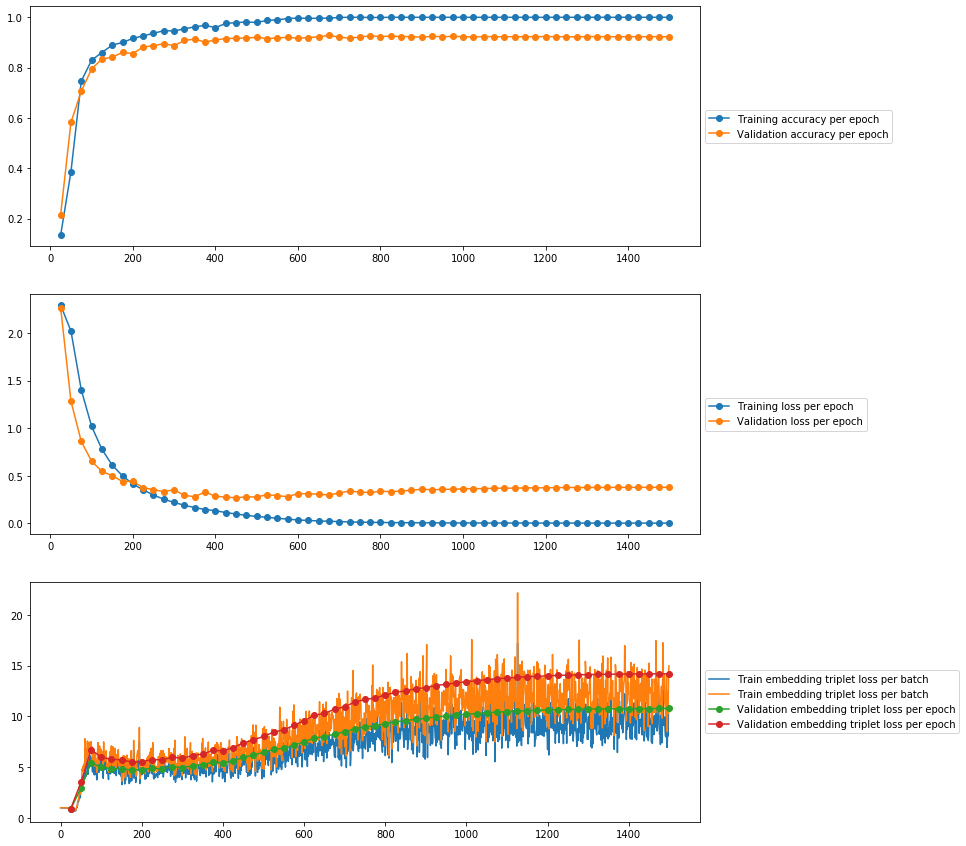

In [14]:
validator.plot()

In [15]:
model2 = SelectiveSequential(
    ['fc1', 'fc2', 'out'],
    {'conv32a': nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
     #'batch32a': nn.BatchNorm2d(32),
     'act32a': nn.ReLU(),
    
     'conv32b': nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
     #'batch32b': nn.BatchNorm2d(32),
     'act32b': nn.ReLU(),
     
     'max1': nn.MaxPool2d(kernel_size=2, stride=2),
    
     'conv64a': nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
     #'batch64a': nn.BatchNorm2d(64),
     'act64a': nn.ReLU(),
     
     'conv64b': nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
     #'batch64b': nn.BatchNorm2d(64),
     'act64b': nn.ReLU(),
    
     'max2': nn.MaxPool2d(kernel_size=2, stride=2),
    
     'conv128a': nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
     #'batch128a': nn.BatchNorm2d(128),
     'act128a': nn.ReLU(),
     
     'conv128b': nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
     # 'batch128b': nn.BatchNorm2d(128),
     'act128b': nn.ReLU(),
     
     # 'max3': nn.MaxPool2d(kernel_size=2, stride=2),
    
     'flatten': Flatten(),
    
     'fc1': nn.Linear(7 * 7 * 128, 512),
     #'drop1': nn.Dropout(.05),
     'fc2': nn.Linear(512, 256),
     #'drop1': nn.Dropout(.05),
     'out': nn.Linear(256, 10)})

In [16]:
criterion = TripletRegularizedCrossEntropyLoss(0.25, 1)

In [17]:
sess = Session(model2, criterion, optim.Adam, 1e-4)

In [19]:
validator2 = EmbeddingSpaceValidator(valloader, 2, CustomOneHotAccuracy)
lr_scheduler2 = CosAnneal(len(trainloader) * 60, T_mult=1, lr_min=1e-6)
schedule2 = TrainingSchedule(trainloader, [lr_scheduler2, validator2])
sess.train(schedule2, 60)

Validating: 100%|██████████| 70/70 [00:01<00:00, 40.03it/s]


Validating: 100%|██████████| 70/70 [00:01<00:00, 40.55it/s]


Validating: 100%|██████████| 70/70 [00:01<00:00, 40.25it/s]


Validating: 100%|██████████| 70/70 [00:01<00:00, 35.66it/s]


Validating: 100%|██████████| 70/70 [00:01<00:00, 38.68it/s]


Validating: 100%|██████████| 70/70 [00:01<00:00, 39.67it/s]


Validating: 100%|██████████| 70/70 [00:01<00:00, 40.16it/s]


Validating: 100%|██████████| 70/70 [00:01<00:00, 38.50it/s]


Validating: 100%|██████████| 70/70 [00:01<00:00, 38.87it/s]


Validating: 100%|██████████| 70/70 [00:01<00:00, 37.27it/s]


Validating: 100%|██████████| 70/70 [00:01<00:00, 41.03it/s]


Validating: 100%|██████████| 70/70 [00:01<00:00, 39.78it/s]


Validating: 100%|██████████| 70/70 [00:01<00:00, 41.01it/s]


Validating: 100%|██████████| 70/70 [00:01<00:00, 37.62it/s]


Validating: 100%|██████████| 70/70 [00:01<00:00, 38.83it/s]


Validating: 100%|██████████| 70/70 [00:01<00:00, 36.87it/s]


Validating: 100%|██████████| 70/70 [00:01<00:00, 39.77it/s]


Validating: 100%|██████████| 70/70 [00:01<00:00, 39.37it/s]


Validating: 100%|██████████| 70/70 [00:01<00:00, 40.06it/s]


Validating: 100%|██████████| 70/70 [00:01<00:00, 39.50it/s]


Validating: 100%|██████████| 70/70 [00:01<00:00, 38.91it/s]


Validating: 100%|██████████| 70/70 [00:01<00:00, 38.69it/s]


Validating: 100%|██████████| 70/70 [00:01<00:00, 38.12it/s]


Validating: 100%|██████████| 70/70 [00:01<00:00, 39.17it/s]


Validating: 100%|██████████| 70/70 [00:01<00:00, 38.59it/s]


Validating: 100%|██████████| 70/70 [00:01<00:00, 38.64it/s]


Validating: 100%|██████████| 70/70 [00:01<00:00, 38.30it/s]


Validating: 100%|██████████| 70/70 [00:01<00:00, 37.14it/s]


Validating: 100%|██████████| 70/70 [00:01<00:00, 36.84it/s]


Validating: 100%|██████████| 70/70 [00:01<00:00, 39.03it/s]


Validating: 100%|██████████| 70/70 [00:01<00:00, 38.73it/s]


Validating: 100%|██████████| 70/70 [00:01<00:00, 37.54it/s]


Validating: 100%|██████████| 70/70 [00:01<00:00, 37.89it/s]


Validating: 100%|██████████| 70/70 [00:01<00:00, 35.62it/s]


Validating: 100%|██████████| 70/70 [00:01<00:00, 36.07it/s]


Validating: 100%|██████████| 70/70 [00:01<00:00, 35.51it/s]


Validating: 100%|██████████| 70/70 [00:01<00:00, 39.70it/s]


Validating: 100%|██████████| 70/70 [00:01<00:00, 38.02it/s]


Validating: 100%|██████████| 70/70 [00:01<00:00, 38.34it/s]


Validating: 100%|██████████| 70/70 [00:01<00:00, 39.53it/s]


Validating: 100%|██████████| 70/70 [00:01<00:00, 40.60it/s]


Validating: 100%|██████████| 70/70 [00:01<00:00, 36.39it/s]


Validating: 100%|██████████| 70/70 [00:01<00:00, 38.79it/s]


Validating: 100%|██████████| 70/70 [00:01<00:00, 39.46it/s]


Validating: 100%|██████████| 70/70 [00:01<00:00, 38.98it/s]


Validating: 100%|██████████| 70/70 [00:01<00:00, 40.69it/s]


Validating: 100%|██████████| 70/70 [00:01<00:00, 39.67it/s]


Validating: 100%|██████████| 70/70 [00:01<00:00, 37.93it/s]


Validating: 100%|██████████| 70/70 [00:01<00:00, 37.48it/s]


Validating: 100%|██████████| 70/70 [00:01<00:00, 36.81it/s]


Validating: 100%|██████████| 70/70 [00:01<00:00, 37.36it/s]


Validating: 100%|██████████| 70/70 [00:01<00:00, 40.18it/s]


Validating: 100%|██████████| 70/70 [00:01<00:00, 40.32it/s]


Validating: 100%|██████████| 70/70 [00:01<00:00, 40.74it/s]


Validating: 100%|██████████| 70/70 [00:01<00:00, 40.76it/s]


Validating: 100%|██████████| 70/70 [00:01<00:00, 37.66it/s]


Validating: 100%|██████████| 70/70 [00:01<00:00, 37.02it/s]


Validating: 100%|██████████| 70/70 [00:01<00:00, 37.50it/s]


Validating: 100%|██████████| 70/70 [00:01<00:00, 38.67it/s]


Validating: 100%|██████████| 70/70 [00:01<00:00, 40.52it/s]


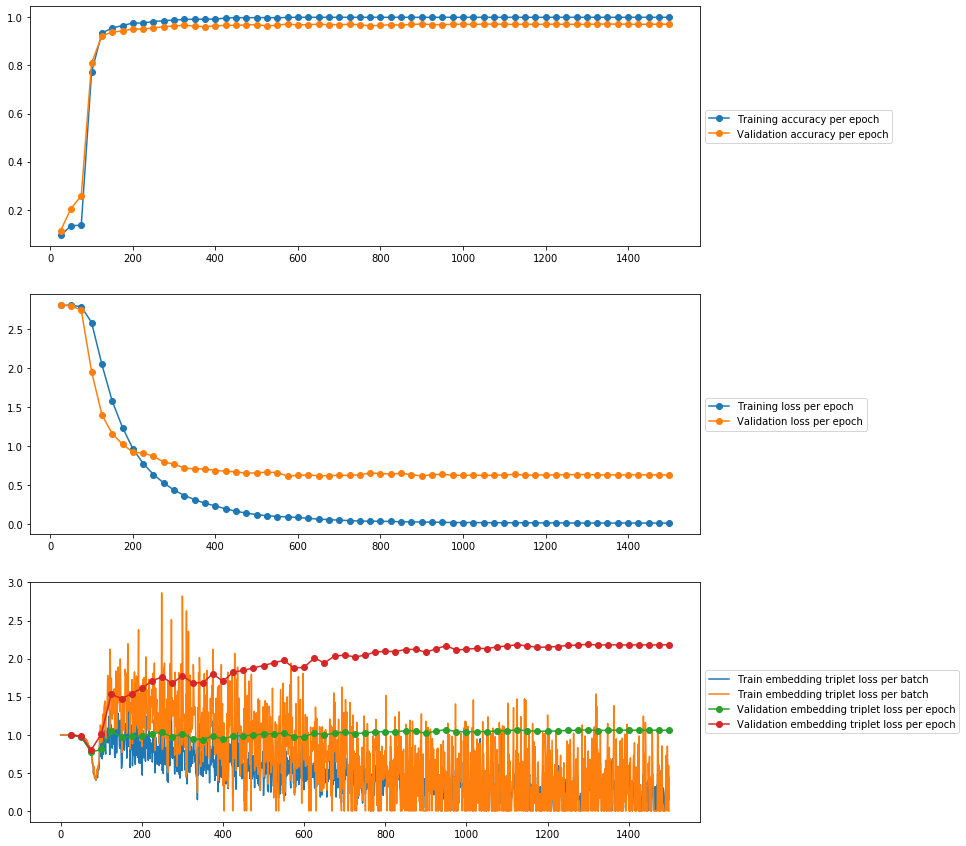

In [20]:
validator2.plot()

In [23]:
np.max(validator2.val_accuracies), "Best accuracy with reg"

0.9723214285714286

In [24]:
np.max(validator.val_accuracies), "Best accuracy without reg"

0.9283482142857142